### 바른자세 모델 확인 코드

In [1]:
import tensorflow as tf
import sys
import os
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import numpy as np
import cv2

model = load_model('./model/03-0.3147final_project.hdf5')
model.summary()

model_hip = load_model('./model/03-0.2348final_project_hip.hdf5')
model_hip.summary()

model_legs = load_model('./model/03-0.4615final_project_legs.hdf5')
model_legs.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 15,239,170
Trainable params: 524,482
Non-trainable params: 14,714,688
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
__________________

In [28]:
# 포인트 찾기
def output_keypoints(frame, proto_file, weights_file, threshold, model_name, BODY_PARTS):
    global points
    # 네트워크 불러오기
    net = cv2.dnn.readNetFromCaffe(proto_file, weights_file)

    # 입력 이미지의 사이즈 정의
    image_height = 368
    image_width = 368

    # 네트워크에 넣기 위한 전처리
    input_blob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (image_width, image_height), (0, 0, 0), swapRB=False, crop=False)

    # mean: 만약 image의 채널이 BGR 순서이고, swapRB가 true이면 R 평균, G평균, B 평균 순서로 값 지정
    # swapRB : 첫 번째 채널과 3번째 채널을 서로 바꿀 것인지를 결정하는 flag.
    # 이 값이 true이면 컬러 입력 영상의 채널 순서를 BGR에서 RGB로 변경
    # crop : 입력 영상(image)의 크기를 변경한 후, crop을 수행할 것인지를 결정하는 flag
    # network입력을 위한 blob으로 변환(blob: 영상 등의 data를 포함할수 있는 다차원 data 표현 방식)
    
    # 전처리된 blob 네트워크에 입력
    net.setInput(input_blob)

    # 결과 받아오기
    out = net.forward()
    out_height = out.shape[2]
    out_width = out.shape[3]

    # 원본 이미지의 높이, 너비를 받아오기
    frame_height, frame_width = frame.shape[:2]

    # 포인트 리스트 초기화
    points = []

    print(f"\n============================== {model_name} Model ==============================")
    for i in range(len(BODY_PARTS)):

        # 신체 부위의 confidence map
        prob_map = out[0, i, :, :]

        # 최소값, 최대값, 최소값 위치, 최대값 위치
        min_val, prob, min_loc, point = cv2.minMaxLoc(prob_map)

        # 원본 이미지에 맞게 포인트 위치 조정
        x = (frame_width * point[0]) / out_width
        x = int(x)
        y = (frame_height * point[1]) / out_height
        y = int(y)

        if prob > threshold:  # [pointed] 
            # cv.circle(그림, 중심, 크기, 색상, 두께(-1이면 꽉채움), 선 유형)
            cv2.circle(frame, (x, y), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            # cv2.putText(그림, 문구, 시작좌표, 폰트종류, 폰트크기, 색상, 사이즈, 선 유형)
            cv2.putText(frame, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1, lineType=cv2.LINE_AA)

            points.append((x, y))
            print(f"[pointed] {BODY_PARTS[i]} ({i}) => prob: {prob:.5f} / x: {x} / y: {y}")

        else:  # [not pointed]
            cv2.circle(frame, (x, y), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frame, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1, lineType=cv2.LINE_AA)

            points.append(None)
            print(f"[not pointed] {BODY_PARTS[i]} ({i}) => prob: {prob:.5f} / x: {x} / y: {y}")

    cv2.imshow("Output_Keypoints", frame)
    cv2.waitKey(0)

# 포인트 선 그리기
def output_keypoints_with_lines(frame, POSE_PAIRS):
    print()
    for pair in POSE_PAIRS:
        part_a = pair[0]  # 0 (Head)
        part_b = pair[1]  # 1 (Neck)
        if points[part_a] and points[part_b]:  # 선 그리기
            print(f"[linked] {part_a} {points[part_a]} <=> {part_b} {points[part_b]}")
            cv2.line(frame, points[part_a], points[part_b], (0, 255, 0), 3)
        else:  # 선 그리지 않기
            print(f"[not linked] {part_a} {points[part_a]} <=> {part_b} {points[part_b]}")

    cv2.imshow("output_keypoints_with_lines", frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    
# 포인트 선 이미지화
def output_lines_image(frame, POSE_PAIRS):
    print()
    for pair in POSE_PAIRS:
        part_a = pair[0]  # 0 (Head)
        part_b = pair[1]  # 1 (Neck)

        if points[part_a] and points[part_b]:  # 선 그리기
            print(f"[linked] {part_a} {points[part_a]} <=> {part_b} {points[part_b]}")
            cv2.line(frame, points[part_a], points[part_b], (0, 255, 0), 3)
        else:  # 선 그리지 않기
            print(f"[not linked] {part_a} {points[part_a]} <=> {part_b} {points[part_b]}")
    cv2.imwrite('testfile.png', frame)   # 테스트 파일 저장
    cv2.imshow("output_keypoints_with_lines", frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
BODY_PARTS_BODY_25 = {0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist",
                      5: "LShoulder", 6: "LElbow", 7: "LWrist", 8: "MidHip", 9: "RHip",
                      10: "RKnee", 11: "RAnkle", 12: "LHip", 13: "LKnee", 14: "LAnkle",
                      15: "REye", 16: "LEye", 17: "REar", 18: "LEar", 19: "LBigToe",
                      20: "LSmallToe", 21: "LHeel", 22: "RBigToe", 23: "RSmallToe", 24: "RHeel", 25: "Background"}

POSE_PAIRS_BODY_25 = [[0, 1], [0, 15], [0, 16], [1, 2], [1, 5], [1, 8], [8, 9], [8, 12], [9, 10], [12, 13], [2, 3],
                      [3, 4], [5, 6], [6, 7], [10, 11], [13, 14], [15, 17], [16, 18], [14, 21], [19, 21], [20, 21],
                      [11, 24], [22, 24], [23, 24]]

# 신경 네트워크의 구조를 지정하는 prototxt 파일 (다양한 계층이 배열되는 방법 등)
protoFile_body_25 = "C:/Users/leesu/model/pose_estimation/openpose-master/openpose-master/models/pose/body_25/pose_deploy.prototxt"

# 훈련된 모델의 weight 를 저장하는 caffemodel 파일
weightsFile_body_25 = "C:/Users/leesu/model/pose_estimation/openpose-master/openpose-master/models/pose/body_25/pose_iter_584000.caffemodel"

# 이미지 경로
test = "C:/Users/leesu/model/pose_estimation/openpose-master/S3.png"
back = "C:/Users/leesu/model/pose_estimation/openpose-master/H.png"
# 키포인트를 저장할 빈 리스트
points = []

# 이미지 읽어오기
frame_body_25 = cv2.imread(test)
frame_body = cv2.imread(back)

# BODY_25 Model
frame_BODY_25 = output_keypoints(frame=frame_body_25, proto_file=protoFile_body_25, weights_file=weightsFile_body_25,
                             threshold=0.2, model_name="BODY_25", BODY_PARTS=BODY_PARTS_BODY_25)
output_keypoints_with_lines(frame=frame_body_25, POSE_PAIRS=POSE_PAIRS_BODY_25)
output_lines_image(frame=frame_body, POSE_PAIRS=POSE_PAIRS_BODY_25)


============================== BODY_25 Model ==============================
[pointed] Nose (0) => prob: 0.75440 / x: 153 / y: 75
[pointed] Neck (1) => prob: 0.65629 / x: 141 / y: 126
[pointed] RShoulder (2) => prob: 0.48232 / x: 98 / y: 126
[pointed] RElbow (3) => prob: 0.71444 / x: 86 / y: 215
[pointed] RWrist (4) => prob: 0.81988 / x: 92 / y: 291
[pointed] LShoulder (5) => prob: 0.54485 / x: 190 / y: 139
[pointed] LElbow (6) => prob: 0.83866 / x: 209 / y: 202
[pointed] LWrist (7) => prob: 0.65383 / x: 184 / y: 253
[pointed] MidHip (8) => prob: 0.47802 / x: 141 / y: 265
[pointed] RHip (9) => prob: 0.45769 / x: 116 / y: 265
[pointed] RKnee (10) => prob: 0.50694 / x: 104 / y: 404
[pointed] RAnkle (11) => prob: 0.67699 / x: 104 / y: 506
[pointed] LHip (12) => prob: 0.44368 / x: 166 / y: 278
[pointed] LKnee (13) => prob: 0.50349 / x: 166 / y: 392
[pointed] LAnkle (14) => prob: 0.62134 / x: 153 / y: 518
[pointed] REye (15) => prob: 0.84617 / x: 147 / y: 63
[pointed] LEye (16) => prob: 0.7

(898, 1096, 3)


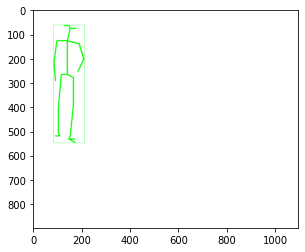

In [20]:
# 테스트 선 이미지 파일 확인

testfile="C:/Users/leesu/testfile.png"
testfile= cv2.imread(testfile)
plt.imshow(testfile)
print(testfile.shape)

img_gray = cv2.cvtColor(testfile, cv2.COLOR_BGR2GRAY)

# 이미지중 선이미지를 찾아 표시
# 컨투어란, 윤곽이라는 뜻 opencv에서 영상이나 이미지의 외곽 혹은 내곽 검출
# findContours 함수를 통해 이진화 이미지에서 윤곽선 찾아냄.
ret, img_th = cv2.threshold(img_gray, 150, 230, cv2.THRESH_BINARY_INV)
contours, hierachy =cv2.findContours(img_th.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(each) for each in contours]
for rect in rects:
    cv2.rectangle(testfile, (rect[0], rect[1]),
                 (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0),1)
    # cv2.rectangle(사진, 왼쪽위 좌표, 오른쪽아래 좌표 , 선의 색, 선의 두께)
plt.imshow(testfile)

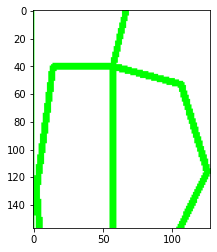

In [29]:
image = testfile.copy()
# 부위별 슬라이싱(어깨 틀어짐)
shoulder_a = int(rect[1]+rect[2]*0.2)
shoulder_b = int(rect[3]*0.5)

shoulder_image = image[shoulder_a:shoulder_b, rect[0]:rect[0] + rect[2]] # Slicing to crop the image

plt.imshow(shoulder_image)

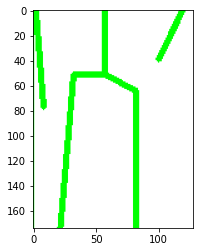

In [30]:
# 부위별 슬라이싱(골반 틀어짐)
hip_a = int(rect[1]+rect[2]*1.2)
hip_b = int(rect[3]*0.8)

hip_image = image[hip_a:hip_b, rect[0]:rect[0] + rect[2]]

plt.imshow(hip_image)

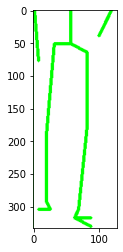

In [31]:
# 부위별 슬라이싱(오다리)
legs_a = int(rect[1]+rect[2]*1.2)
legs_image = image[legs_a:rect[1]+rect[3], rect[0]:rect[0] + rect[2]]

plt.imshow(legs_image)

In [32]:
# 테스트 선 이미지 파일 크기 조정
shoulder_image= cv2.resize(shoulder_image.astype('float32'), dsize=(150, 150))
hip_image = cv2.resize(hip_image.astype('float32'), dsize=(150, 150))
legs_image= cv2.resize(legs_image.astype('float32'), dsize=(150, 150))

In [33]:
# 선 이미지 파일 shape 조정
print(shoulder_image.shape)
shoulder_image = shoulder_image.reshape(-1,150,150,3).astype('float32')/255
print(shoulder_image.shape)

print(hip_image.shape)
hip_image = hip_image.reshape(-1,150,150,3).astype('float32')/255
print(hip_image.shape)

print(legs_image.shape)
legs_image = legs_image.reshape(-1,150,150,3).astype('float32')/255
print(legs_image.shape)

(150, 150, 3)
(1, 150, 150, 3)
(150, 150, 3)
(1, 150, 150, 3)
(150, 150, 3)
(1, 150, 150, 3)


In [34]:
# 결과 확인
# 어깨 틀어짐 확인
shoulder_predict=list()
shoulder_predict.append(model.predict(shoulder_image))

print('자세 상태의 각 확률은 ', model.predict(shoulder_image))

if shoulder_predict[0].argmax() == 0:  # argmax 확률 높은 거 뽑아냄
    shoulder = '정상'
    
elif shoulder_predict[0].argmax() == 1:
    shoulder = '틀어짐'
    

# 허리 틀어짐 확인
hip_predict=list()
hip_predict.append(model_hip.predict(hip_image))

print('자세 상태의 각 확률은 ', model_hip.predict(hip_image))

if hip_predict[0].argmax() == 1:  # argmax 확률 높은 거 뽑아냄
    hip = '정상'
    
elif hip_predict[0].argmax() == 0:
    hip = '틀어짐'


#  오다리 확인
legs_predict=list()
legs_predict.append(model_legs.predict(legs_image))

print('자세 상태의 각 확률은 ', model_legs.predict(legs_image))

if legs_predict[0].argmax() == 1:  # argmax 확률 높은 거 뽑아냄
    legs = '정상'
    
elif legs_predict[0].argmax() == 0:
    legs = '오다리'
    
# 최종 결과
print('어깨 상태는', shoulder, '입니다.')
print('골반 상태는', hip, '입니다.')
print('다리 상태는', legs, '입니다.')

자세 상태의 각 확률은  [[0.36682895 0.6331711 ]]
자세 상태의 각 확률은  [[0.8860574  0.11394265]]
자세 상태의 각 확률은  [[0.77437353 0.22562645]]
어깨 상태는 틀어짐 입니다.
골반 상태는 틀어짐 입니다.
다리 상태는 오다리 입니다.
